In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval, fmin

import warnings
warnings.filterwarnings('ignore')

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается взглянуть на задачу моделирования количества страховых случаев как на задачу многоклассовой классификации.

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

Предобработайте данные

In [4]:
df['ClaimsCount'] = df['ClaimInd'] + df['ClaimNbResp'] + df['ClaimNbNonResp'] + df['ClaimNbParking'] + df['ClaimNbFireTheft'] + df['ClaimNbWindscreen']
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", 
         "ClaimNbWindscreen", 'RecordBeg', 'RecordEnd', 'SocioCateg'], axis=1, inplace=True)

NegClaimAmount = df.loc[df.ClaimAmount < 0, ['ClaimAmount','ClaimInd']]
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
df.loc[df['ClaimsCount'] > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']

df['Gender'] = df['Gender'].map({'Male':1, 'Female':2})
df['MariStat'] = df['MariStat'].map({'Other':1, 'Alone':2})
df['VehUsage'] = df['VehUsage'].map({'Professional':1, 'Private+trip to office':2, 'Private':3, 'Professional run':4})


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Exposure     115155 non-null  float64
 1   LicAge       115155 non-null  int64  
 2   Gender       115155 non-null  int64  
 3   MariStat     115155 non-null  int64  
 4   VehUsage     115155 non-null  int64  
 5   DrivAge      115155 non-null  int64  
 6   HasKmLimit   115155 non-null  int64  
 7   BonusMalus   115155 non-null  int64  
 8   ClaimAmount  115155 non-null  float64
 9   ClaimInd     115155 non-null  int64  
 10  OutUseNb     115155 non-null  float64
 11  RiskArea     115155 non-null  float64
 12  ClaimsCount  115155 non-null  float64
 13  AvgClaim     11546 non-null   float64
dtypes: float64(6), int64(8)
memory usage: 12.3 MB


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [6]:
df.ClaimsCount.value_counts()

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
5.0        441
6.0        128
7.0         26
8.0          6
9.0          2
11.0         1
Name: ClaimsCount, dtype: int64

In [7]:
df.loc[(df.ClaimsCount == 11),'ClaimsCount'] = 10

Примеров с меткой 10,9, 8, 7, 6 - экстремально мала - размножим их просто дописав по тексту n раз 

In [8]:
ff = df.loc[(df.ClaimsCount == 10)|(df.ClaimsCount == 9)|(df.ClaimsCount == 8)|(df.ClaimsCount == 7),:] 
n = 10
for i in range(n):
  df = pd.concat([df,ff])
df.ClaimsCount.value_counts() 

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
5.0        441
7.0        286
6.0        128
8.0         66
9.0         22
10.0        11
Name: ClaimsCount, dtype: int64

 и еще разок только для  6,10,9, 8 при n=5

In [9]:
ff = df.loc[(df.ClaimsCount == 6)|(df.ClaimsCount == 10)|(df.ClaimsCount == 9)|(df.ClaimsCount == 8),:] 
n = 5
for i in range(n):
  df = pd.concat([df,ff])
df.ClaimsCount.value_counts()  

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
6.0        768
5.0        441
8.0        396
7.0        286
9.0        132
10.0        66
Name: ClaimsCount, dtype: int64

Собираем алгоритм классификатора

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score




x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(df.iloc[-10000:,:2], df.ClaimsCount.values[-10000:] , test_size=0.3, random_state=1)
x_valid_cl, x_test_cl, y_valid_cl, y_test_cl = train_test_split(x_test_cl, y_test_cl, test_size=0.5, random_state=1)


фрейм данных для обучения, валидации и тестов

In [11]:
train_cl = xgb.DMatrix(x_train_cl, y_train_cl)
valid_cl = xgb.DMatrix(x_valid_cl, y_valid_cl)
test_cl = xgb.DMatrix(x_test_cl, y_test_cl)

Убедимся , что все метки есть во всех пакетах

In [12]:
print(np.unique(train_cl.get_label()))
print(np.unique(test_cl.get_label()))
print(np.unique(valid_cl.get_label()))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Параметры для генерации модели

In [13]:
params_cl ={
            'max_depth': 3,  # глубина дерева
            'eta': 0.3,  # шаг обучения
            'num_class': 11,  # число классов
      
            'objective': 'multi:softmax',  # выход модели (фактически строим 11 моделей, но перевзвесили по софтмаксу)
            'silent':1 # молча, без логов 
            }

train_params_cl = {'num_boost_round': 300,

                'maximize': False,
                'verbose_eval': False}


progress_cl = dict()
xgb_cl = xgb.train(params=params_cl, dtrain=train_cl, early_stopping_rounds=10,
                     evals=[(train_cl, "train"), (valid_cl, "valid")])

[21:52:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.18814	valid-merror:0.18333
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.18057	valid-merror:0.17733
[2]	train-merror:0.17271	valid-merror:0.16933
[3]	train-merror:0.16657	valid-merror:0.16200
[4]	train-merror:0.16657	valid-merror:0.16200
[5]	train-merror:0.16700	valid-merror:0.16267
[6]	train-merror:0.16786	valid-merror:0.16133
[7]	train-merror:0.16914	valid-merror:0.16067
[8]	train-merror:0.16314	valid-merror:0.15267
[9]	train-merror:0.15629	valid-merror:0.14267


Предсказываем и проверяем на аккуратность

In [14]:

y_pred = xgb_cl.predict(xgb.DMatrix(df.iloc[:,:2])) 


accuracy = accuracy_score(df.ClaimsCount, y_pred) 
print(accuracy)




0.8736968449931413


И рисуночек

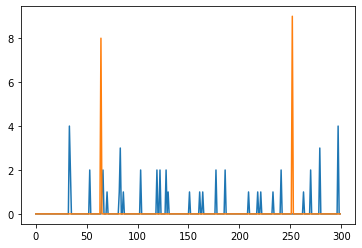

In [15]:
plt.plot(df.ClaimsCount[:300])
plt.plot(y_pred[:300])
plt.show()


Посмотрим, сколько полисов соответствуют каждому из значений `ClaimsCount`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [16]:
FreqCount = pd.DataFrame(y_pred, columns=['Count'])
FreqCount['Count'].value_counts()

0.0     113103
6.0       2187
8.0        713
9.0        421
10.0       214
7.0          2
Name: Count, dtype: int64

In [17]:
FreqCount

,Count
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
116635,8.0
116636,9.0
116637,8.0
116638,8.0


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.05` для значений `ClaimsCount` 0, а для остальных - 1 (Для этого можем использовать функцию `np.where`). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [18]:
df['weight'] = 1
df.loc[df['ClaimsCount'] == 0.0, 'weight'] = 0.05

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [19]:
target = 'ClaimsCount'

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [20]:
xgb_train = xgb.DMatrix(X_train, y_train, weight=X_train['weight'])
xgb_valid = xgb.DMatrix(X_valid, y_valid)
xgb_test = xgb.DMatrix(X_test, y_test)

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [22]:
params ={
    'max_depth': 3, 
    'eta': 0.3,  
    'num_class': 11,   
}

train_params = {
    'num_boost_round': 300,
    'maximize': False,
    'verbose_eval': False   
}

Далее обучим нашу модель с оптимальными параметрами

In [24]:
xgb = xgb.train(params=params, dtrain=xgb_train, early_stopping_rounds=10,
                evals=[(xgb_train, "train"), (xgb_valid, "valid")])

[0]	train-merror:0.37624	valid-merror:0.05933
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.34000	valid-merror:0.05401
[2]	train-merror:0.31693	valid-merror:0.05007
[3]	train-merror:0.28458	valid-merror:0.04538
[4]	train-merror:0.26805	valid-merror:0.04298
[5]	train-merror:0.26571	valid-merror:0.04361
[6]	train-merror:0.25309	valid-merror:0.04121
[7]	train-merror:0.23204	valid-merror:0.03858
[8]	train-merror:0.21053	valid-merror:0.03555
[9]	train-merror:0.19759	valid-merror:0.03355


Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [27]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.9689520870076426
F1 Score on valid: 0.9664494741655235
F1 Score on test: 0.9667924096936443


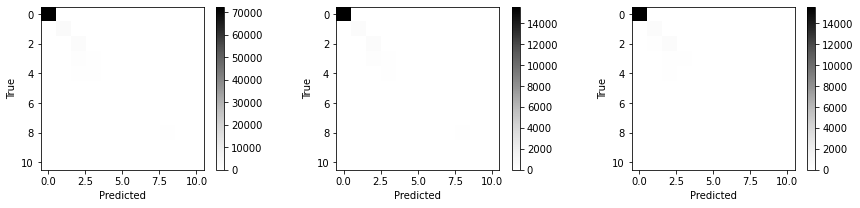

In [29]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()